# Developing Trading Strategies with Genetic Algorithm
## Annex : In-Sample vs. Out-of-sample Regressions 
### Introduction
This notebook is an annex to the [Lean](https://github.com/QuantConnect/Lean) Project ***Trading Rules based in Genetic Algorithms***. The main post can be found [here](https://www.quantconnect.com/forum).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 8
%matplotlib inline

base_path = '/run/media/jjd/Win7/Users/jjd/Desktop/GAExperiment_2017-05-28_0211/'

### Fitness by Generations
The genetic algorithm ran for 32 generations. The session was ending after a  fitness stagnation for 9 generation.

The paper uses Sterling ratio as fitness:
$$SterlingRatio = \frac{NetProfit}{MaxDrawdown}$$

The Net Profit instead the Annualized return because the training period was of six months.

In order to avoid negative fitness issues, this study used:
$$fitness = 2^{SterlingRatio}$$

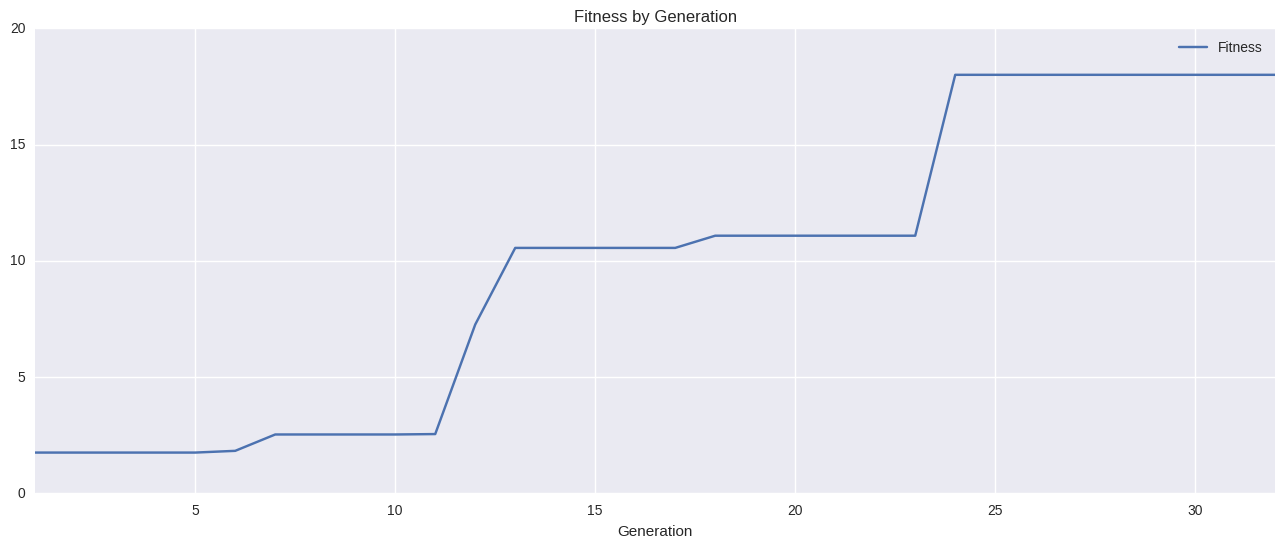

In [2]:
fitness_by_generation_file = base_path + 'FitnessByGeneration.csv' 
fitness_by_generation = pd.read_csv(fitness_by_generation_file)
fitness_by_generation.plot(x='Generation', y='Fitness', title='Fitness by Generation', figsize=(16,6));

The fitness shows a typical pattern in genetic algorithms, that is, many generations of fitness stagnation until a new innovation reaches new highs.

### Fitness by individuals

The number of individuals tested in the learning session was **1873**. 

In [3]:
# Read the data of all individual generated by the genetic algorithm and apply CamleCase format for the column names.
optimization_resutls = base_path + 'ResultsNoUnits.csv'
ga_results = pd.read_csv(optimization_resutls, )
camel_column_name = [n.replace(" ", "") for n in ga_results.columns]
ga_results.columns = camel_column_name

# The simple order in which the backtest results were saved will be used as individuals identification for further comparison.
ga_results['ID'] = ga_results.index

In [4]:
print('Total individuals:', ga_results.shape[0])

Total individuals: 1873


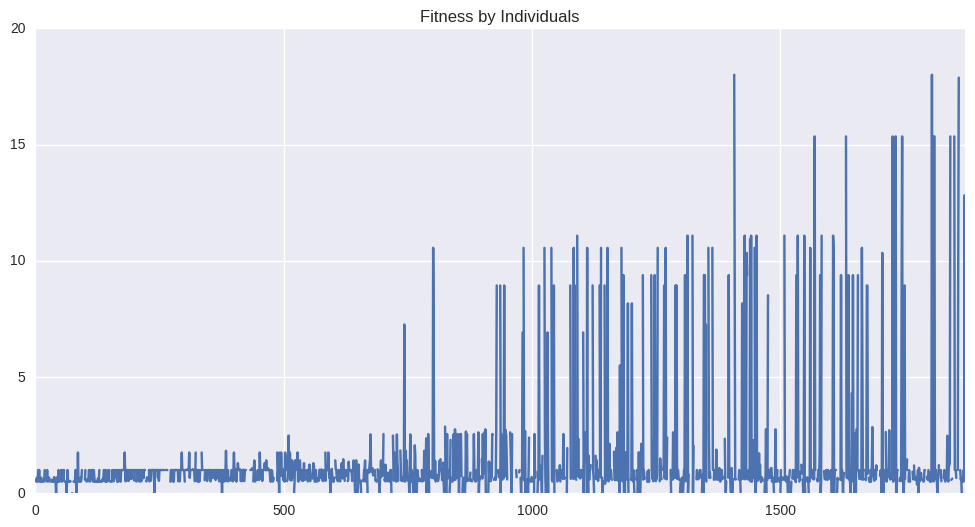

In [5]:
ga_results['SterlingRatio'] = ga_results.NetProfit / ga_results.Drawdown
ga_results['Fitness'] = 2 ** ga_results.SterlingRatio
ga_results.Fitness.plot(figsize=(12,6), title='Fitness by Individuals');

In [6]:
print('Cases with zero Total Trades:', ga_results[ga_results.TotalTrades==0].shape[0])

Cases with zero Total Trades: 249


In [7]:
print('Cases with zero Drawdown:', ga_results[ga_results.Drawdown==0].shape[0])

Cases with zero Drawdown: 456


In [8]:
print('Cases with trades made but zero Drawdown:', ga_results[(ga_results.Drawdown==0) & (ga_results.TotalTrades!=0)].shape[0])

Cases with trades made but zero Drawdown: 207


In [9]:
ga_results = ga_results[ga_results.Drawdown!=0]

The blanks in the plot corresponds to the 456 cases where the **`MaxDrawdown`** is equal to zero. 

From those cases 249 corresponds to cases where the agent was not able to generate signals (**`TotalTrades==0`**), the remaining 207 cases are consequence of some flaws in the experiment design and implementation.

First, the algorithm used to run the evaluations had a very low exposure. The reason for that decision was trying to keep the portfolio in positives values, even when many bad trades were made by the individuals (some individuals made more than 10000 trades!). *The problem with the low exposure is that the draw down is very small*. Second, the **`MaxDrawdown`** value is parsed from a string in percentage format with two decimals; thus, the small draw downs are rounded to zero. 

Another side-effect of this problem is that as the genetic algorithm only checks the fitness when considering the next generation, some of those individuals were completely ignored for the recombination, event when they had a good behavior (the best one has a Sharpe of 1.9).

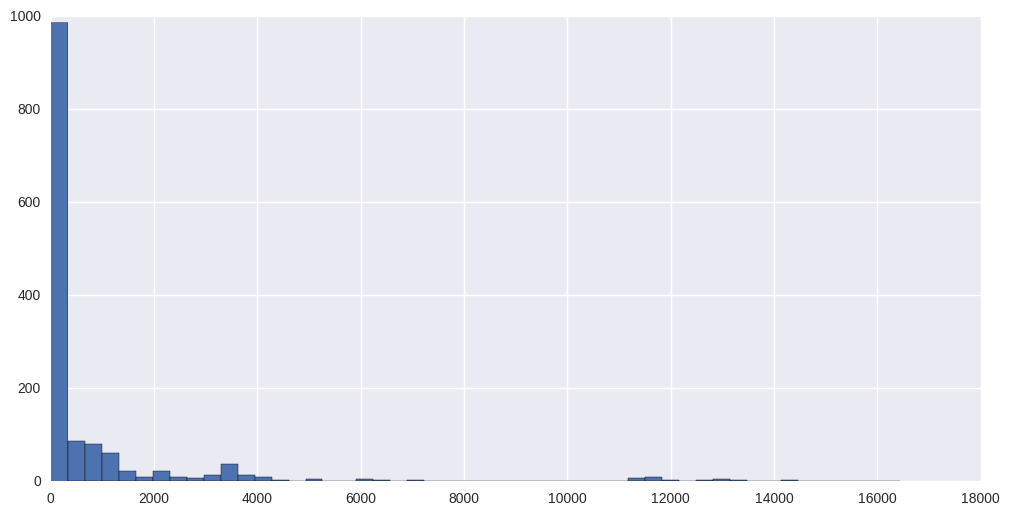

In [10]:
ga_results.TotalTrades.hist(bins=50, figsize=(12,6));

In [11]:
oos_results = ga_results[ga_results.SterlingRatio>1]
cols = ['ID']
cols.extend(ga_results.columns[:28])
# Save file to be used by LeanSTP in the OOS analysis 
#oos_results[cols].to_csv(base_path+'SelectedIndividualsForOOS.csv', index=False)
oos_results.shape[0]

163

## In Sample vs Out of Sample

The training session period was 6 months from July 1st 2016 to December 31th 2016. The out sample period was January 2017.

Only the 40 individuals with Sterling ratio greater than one were considered to run the out of sample analysis.

In [13]:
statistics_cols = ['TotalTrades', 'AverageWin', 'AverageLoss', 'CompoundingAnnualReturn',
                   'Drawdown', 'Expectancy', 'NetProfit', 'SharpeRatio', 'LossRate',
                   'WinRate', 'Profit-LossRatio', 'Alpha', 'Beta', 'AnnualStandardDeviation',
                   'AnnualVariance', 'InformationRatio', 'TrackingError', 'TreynorRatio',
                   'TotalFees', 'ID', 'SterlingRatio']

for i in range(1,5):
    out_of_sample_results = base_path + 'OutOfSample'+str(i)+'Month/FullResutls.csv'
    oos_results = pd.read_csv(out_of_sample_results)
    oos_results['SterlingRatio'] = oos_results.NetProfit / oos_results.Drawdown
    oos_results['OosPeriod'] = str(i) + '_month'
    
    oos_results = oos_results.join(ga_results.ix[:, statistics_cols], on='ID', how='inner',
                                   lsuffix='_OOS', rsuffix='_IS')
    if(i==1):
        oos_vs_is = oos_results
    else:
        oos_vs_is = pd.concat([oos_vs_is, oos_results], axis=0)
    oos_vs_is = oos_vs_is.replace([np.inf, -np.inf], np.nan).fillna(value=0)
    
oos_vs_is.to_csv(base_path + "FullOosResults.csv", index=False)

In [14]:
oos_vs_is

,ID,TotalTrades_OOS,AverageWin_OOS,AverageLoss_OOS,CompoundingAnnualReturn_OOS,Drawdown_OOS,Expectancy_OOS,NetProfit_OOS,SharpeRatio_OOS,LossRate_OOS,...,Alpha_IS,Beta_IS,AnnualStandardDeviation_IS,AnnualVariance_IS,InformationRatio_IS,TrackingError_IS,TreynorRatio_IS,TotalFees_IS,ID_IS,SterlingRatio_IS
0,1005,4,0.0000,-0.0001,-0.00284,0.002,-1.000,-0.00025,-0.386,1.00,...,0,0,0.002,0,0,0,0,68.02,1005,1.35
1,1014,6,0.0054,-0.0048,0.07099,0.006,0.422,0.00603,1.701,0.33,...,0,0,0.003,0,0,0,0,152.06,1014,3.16
2,1025,6,0.0054,-0.0048,0.07099,0.006,0.422,0.00603,1.701,0.33,...,0,0,0.003,0,0,0,0,156.07,1025,3.40
3,1026,6,0.0023,-0.0004,0.01705,0.003,1.271,0.00148,1.616,0.67,...,0,0,0.002,0,0,0,0,60.02,1026,1.24
4,1031,6,0.0054,-0.0048,0.07099,0.006,0.422,0.00603,1.701,0.33,...,0,0,0.003,0,0,0,0,156.06,1031,2.79
5,1032,6,0.0023,-0.0004,0.01705,0.003,1.271,0.00148,1.616,0.67,...,0,0,0.002,0,0,0,0,72.02,1032,1.46
6,1039,6,0.0054,-0.0048,0.07099,0.006,0.422,0.00603,1.701,0.33,...,0,0,0.003,0,0,0,0,156.07,1039,3.40
7,1044,6,0.0054,-0.0048,0.07099,0.006,0.422,0.00603,1.701,0.33,...,0,0,0.003,0,0,0,0,152.06,1044,3.16
8,1059,6,0.0054,-0.0048,0.07099,0.006,0.422,0.00603,1.701,0.33,...,0,0,0.003,0,0,0,0,156.07,1059,3.40
9,1063,4,0.0000,-0.0001,-0.00284,0.002,-1.000,-0.00025,-0.386,1.00,...,0,0,0.002,0,0,0,0,68.02,1063,1.35


In [15]:
x = sm.add_constant(oos_vs_is.SterlingRatio_IS, prepend=False)
y = oos_vs_is.SharpeRatio_OOS
mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        SharpeRatio_OOS   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     136.9
Date:                Wed, 07 Jun 2017   Prob (F-statistic):           7.98e-29
Time:                        14:12:21   Log-Likelihood:                -1146.7
No. Observations:                 652   AIC:                             2297.
Df Residuals:                     650   BIC:                             2306.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
SterlingRatio_IS     0.6282      0.054  

In [16]:
for i in range(1,5):
    sample = str(i) + '_month'
    x = sm.add_constant(oos_vs_is[oos_vs_is.OosPeriod==sample].SterlingRatio_IS, prepend=False)
    y = oos_vs_is[oos_vs_is.OosPeriod==sample].SharpeRatio_OOS
    mod = sm.OLS(y, x)
    res = mod.fit()
    print ("\n\nOut of Sample lenght:", sample )
    print(res.summary())
    print ('='*90)




Out of Sample lenght: 1_month
                            OLS Regression Results                            
Dep. Variable:        SharpeRatio_OOS   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     88.83
Date:                Wed, 07 Jun 2017   Prob (F-statistic):           4.53e-17
Time:                        14:12:38   Log-Likelihood:                -172.60
No. Observations:                 163   AIC:                             349.2
Df Residuals:                     161   BIC:                             355.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Sterling

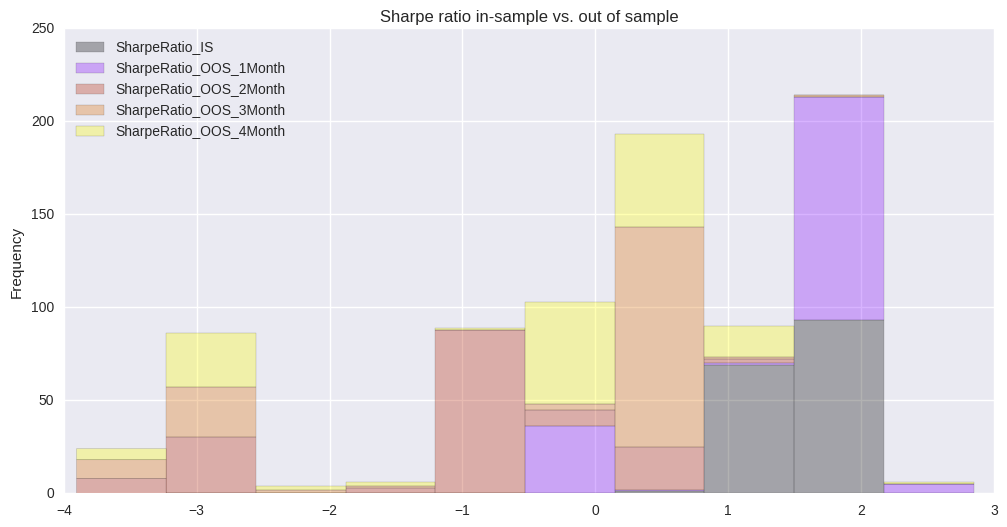

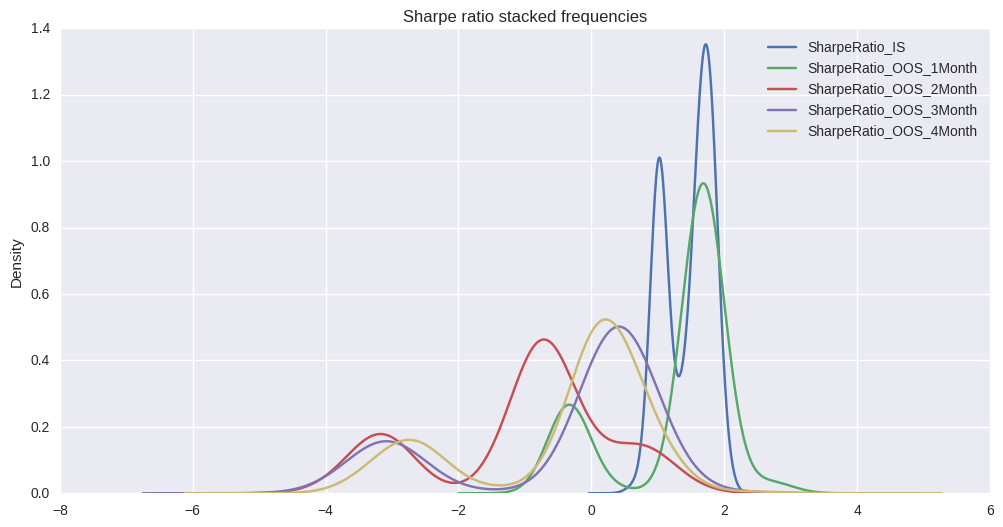

In [17]:
oos_vs_is.OosPeriod.unique()
df_for_kde = pd.DataFrame({"SharpeRatio_IS":oos_vs_is[oos_vs_is.OosPeriod=='1_month'].SharpeRatio_IS,
                           "SharpeRatio_OOS_1Month":oos_vs_is[oos_vs_is.OosPeriod=='1_month'].SharpeRatio_OOS,
                           "SharpeRatio_OOS_2Month":oos_vs_is[oos_vs_is.OosPeriod=='2_month'].SharpeRatio_OOS,
                           "SharpeRatio_OOS_3Month":oos_vs_is[oos_vs_is.OosPeriod=='3_month'].SharpeRatio_OOS,
                           "SharpeRatio_OOS_4Month":oos_vs_is[oos_vs_is.OosPeriod=='4_month'].SharpeRatio_OOS,
                          })
df_for_kde.plot.hist(figsize=(12,6), stacked=True, alpha = 0.3, colormap='gnuplot', title='Sharpe ratio in-sample vs. out of sample');
df_for_kde.plot.kde(figsize=(12,6), title='Sharpe ratio stacked frequencies');
df_for_kde.to_csv(base_path + 'sharpeForKDE.csv')

In [18]:
x = sm.add_constant(oos_vs_is.SterlingRatio_IS, prepend=False)
y = oos_vs_is.SharpeRatio_OOS
mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        SharpeRatio_OOS   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     136.9
Date:                Wed, 07 Jun 2017   Prob (F-statistic):           7.98e-29
Time:                        14:13:17   Log-Likelihood:                -1146.7
No. Observations:                 652   AIC:                             2297.
Df Residuals:                     650   BIC:                             2306.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
SterlingRatio_IS     0.6282      0.054  